## This file:
 1) Loads a pickled batch of brick pictures  
 2) Loads a trained Keras-TensorFlow model basd on InceptionV3  
 3) Takes 1 new picture  
 4) Runs the pictures through the model to make predictions  
 5) Displays pictures from the original batch matching predictions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from PIL import Image, ImageOps
import numpy as np

#import os
import cPickle as pickle
from src import picture_stuff as pix

from keras.models import load_model

Using TensorFlow backend.


In [2]:
use_gray = True

### PART 1: Load pickled data files

In [3]:
with open("data/X_examples.pkl") as f_un:
    X = pickle.load(f_un)

if use_gray:
    X = pix.convert_to_gray(X)

with open("data/y_examples_list.pkl") as f_un:
    y_list = pickle.load(f_un)

In [4]:
picture_index_lookup = {}
for idx,label in enumerate(y_list):
    picture_index_lookup[label]=idx

In [5]:
label_dic_dummy,y_hot = pix.y_to_hot(y_list)

### PART 2: Load pickled Keras-TensorFlow Convolutional Neural Network model

### NOTE: BEFORE LOADING MODEL, CHECK WHICH MODEL VERSION IS NEWEST

In [6]:
filepath = '../saved_models/'
if use_gray:
    with open(filepath + "label_dic-gray.pkl") as f_un:
        label_dic = pickle.load(f_un)
    #fname = filepath + 'keras_inception_all_partially_trained_gray.h5'
    #fname = filepath + 'keras_inception_all_trained_gray.h5'
    fname = filepath + 'keras_example_inception_trained-gray.h5'
else:
    with open(filepath + "label_dic.pkl") as f_un:
        label_dic = pickle.load(f_un)
    fname = filepath + 'keras_example_inception_trained-copy2.h5'

model = load_model(fname)

In [7]:
# DOES label_dic == label_dic_dummy???
for key in label_dic.keys():
    if label_dic[key] != label_dic_dummy[key]:
        print key, label_dic[key], label_dic_dummy[key]

### PART 3: shoot a picture of a brick

In [8]:
image_dims = 299
scale_vals = (image_dims,image_dims)
border_percent = .3

### To repeat and shoot/classify more bricks, "run all below" from here

checkpoint - initialize camera now
Type label (integer as file name):nn
testing: ../brick_pic_temp_files/nn-001.jpeg
Save next picture as:  ../brick_pic_temp_files/nn-001.jpeg


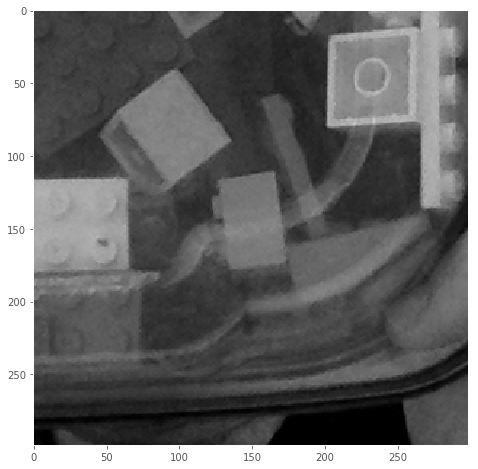

Enter 0:reshoot, any other:save


In [9]:
camera = pix.initialize_camera()

# Input a file name = brick shape: e.g. 3021
pic_label = raw_input('Type label (integer as file name):')
extension = 1
extension, filename = pix.increment_filename(pic_label,extension)


keep_shooting = True
while keep_shooting:

    # Shoot picture, crop and scale
    pic = pix.shoot_pic(camera)
    if use_gray:
        pic = pix.convert_to_gray(pic)
    im = Image.fromarray(pic)
    newpic = ImageOps.fit(im, scale_vals, Image.ANTIALIAS,
                          border_percent, (.5,.5))
    np_newpic = np.array(newpic)
    fig, ax = plt.subplots(1,figsize=(8,8))
    ax.imshow(np_newpic[:,:,::-1], cmap=plt.cm.gray_r, interpolation="nearest")
    ax.grid(False)
    plt.show();

    next_action = raw_input('Enter 0:reshoot, any other:save')

    if next_action != '0':
        pix.save_pic(filename,np_newpic)
        one_pic_X = np_newpic
        one_pic_y = [pic_label]
        keep_shooting = False

if use_gray:
    one_pic_X = pix.convert_to_gray(one_pic_X)
del(camera)

### PART 4: predictions on new brick picture

In [10]:
one_predict_gen = model.predict_on_batch(np.expand_dims(one_pic_X,axis=0))

small_prediction_list, small_prediction_weights = pix.make_full_prediction_list(
    one_predict_gen,label_dic,n_match=5)

In [11]:
preds = small_prediction_list[0]

idx_preds = [picture_index_lookup[pred] for pred in preds]
#act_pic = one_pic_X

print "label for this item {}".format(one_pic_y)
print "Top 5 predictions ", preds

label for this item ['nn']
Top 5 predictions  [30503, 2413, 48933, 50304, 6183]


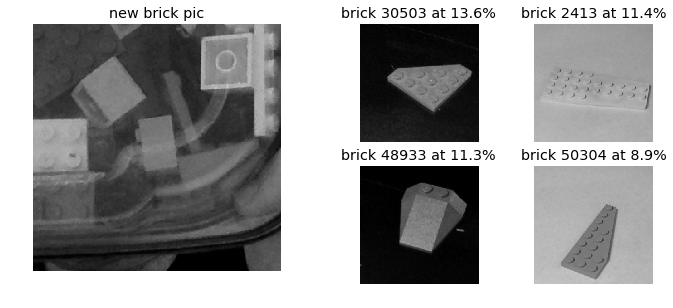

In [13]:
fig, ax = plt.subplots(1,figsize=(12,10))

ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax1.imshow(Image.fromarray(one_pic_X[:,:,::-1]))

ax1.set_title("new brick pic")
ax1.grid(False)
ax1.axis('off')

for idx1 in range(2):
    ax2 = plt.subplot2grid((4, 4), (0,idx1+2))
    ax2.imshow(Image.fromarray(X[idx_preds[idx1]]))
    ax2.set_title("brick {} at {:.1f}%".format(y_list[idx_preds[idx1]],100*small_prediction_weights[0][idx1]))
    ax2.grid(False)
    ax2.axis('off')
    
    ax3 = plt.subplot2grid((4, 4), (1,idx1+2))
    ax3.imshow(Image.fromarray(X[idx_preds[idx1+2]]))
    ax3.set_title("brick {} at {:.1f}%".format(y_list[idx_preds[idx1+2]],100*small_prediction_weights[0][idx1+2]))
    ax3.grid(False)
    ax3.axis('off')

# If you like the figure, save it!
picfilename = ("static/images/saved_brick_predictions/" + str(pic_label) + "_temp.png")
with open(picfilename, 'wb') as whatever:
    fig.savefig(whatever)